In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("2.1.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 658.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=46e60964471c6b0cb4b75c12c92834ae4136a72e357edb725f5d0d622f75a852
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=f8a5d6f0dede2320b3a0a77aaf61d25ec7a1e98216e57f05d3d905fb9699dcee
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 40.1 MB/s eta 0:00:00


Challenge A :1

--2024-02-16 05:29:18--  https://raw.githubusercontent.com/hallpaz/3dsystems20/master/extensions_utils/cube.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1630 (1.6K) [text/plain]
Saving to: ‘./cube.py’

cube.py             100%[===================>]   1.59K  --.-KB/s    in 0s      

2024-02-16 05:29:18 (21.1 MB/s) - ‘./cube.py’ saved [1630/1630]



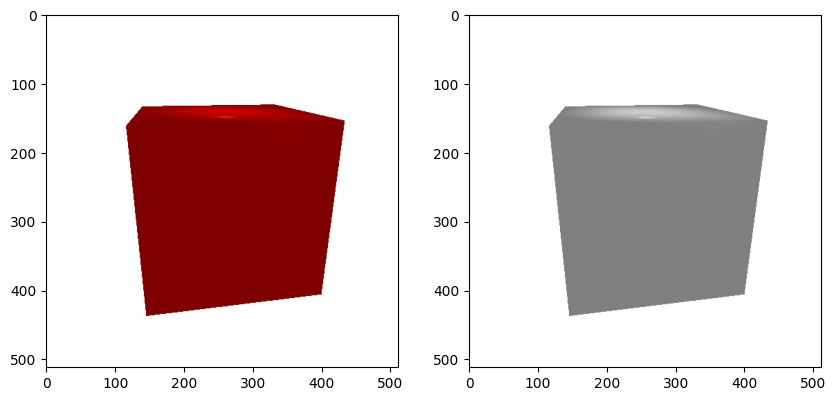

In [2]:

from pytorch3d.structures import Meshes
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

!wget -P . https://raw.githubusercontent.com/hallpaz/3dsystems20/master/extensions_utils/cube.py

# Vertex coordinates for a level 0 cube.
_cube_verts0 = [
    [-0.50, 0.50, 0.50],
    [-0.50, -0.50, 0.50],
    [0.50, -0.50, 0.50],
    [0.50, 0.50, 0.50],

    [-0.50, 0.50, -0.50],
    [-0.50, -0.50, -0.50],
    [0.50, -0.50, -0.50],
    [0.50, 0.50, -0.50]
]


# Faces for level 0 cube
_cube_faces0 = [
    [0, 1, 2],
    [2, 3, 0],
    [7, 6, 5],
    [4, 7, 5],
    [6, 3, 2],
    [3, 6, 7],
    [4, 5, 0],
    [0, 5, 1],
    [3, 4, 0],
    [4, 3, 7],
    [2, 1, 5],
    [5, 6, 2],
]

from cube import cube
refinedcube = cube(1, device=device)
verts_list = [torch.tensor(_cube_verts0, device=device), refinedcube.verts_list()[0]]
faces_list = [torch.tensor(_cube_faces0, dtype=torch.int64, device=device), refinedcube.faces_list()[0]]
mesh_batch = Meshes(verts=verts_list, faces=faces_list)

from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform,
    RasterizationSettings, BlendParams,
    MeshRenderer, MeshRasterizer, HardPhongShader,
    Textures
)

R, T = look_at_view_transform(2, 20, 170)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1, # sets the value of K
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardPhongShader(device=device, cameras=cameras)
)
import matplotlib.pyplot as plt
from pytorch3d.renderer import Textures

new_tex = torch.ones_like(mesh_batch.verts_padded())
new_tex[0,0:mesh_batch.verts_list()[0].size()[0],:]=torch.tensor([1,0,0],device=device)
#new_tex[1,:,:]=torch.tensor([0.,0.,1.0],device=device)

textures = Textures(verts_rgb=new_tex.to(device))
mesh_batch.textures = textures
images = renderer(mesh_batch, cameras=cameras)

def plot_side_by_side(images):
  n = images.shape[0]
  fig = plt.figure(figsize=(10, 10))
  for i in range(n):
    fig.add_subplot(1, n, i+1)
    plt.imshow(images[i, ..., :3].cpu().numpy())
    #plt.grid("off");
    #plt.axis("off");

plot_side_by_side(images)
#print(mesh_batch.verts_padded())
#print(new_tex)

Challenge A :2 (must run after section 1 is executed)

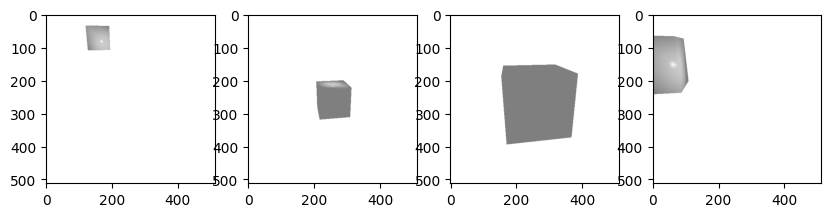

In [3]:
from pytorch3d.transforms import Transform3d, Rotate, Translate, Scale
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform,
    RasterizationSettings, BlendParams,
    MeshRenderer, MeshRasterizer, HardPhongShader,
    Textures
)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

T = Translate(torch.FloatTensor([[1.0, 2.0, 3.0]]), device=device)
R = Rotate(torch.FloatTensor([[0, 1, 0], [0, 0, 1], [1, 0, 0]]), device=device)
S = Scale(torch.tensor(2.0), device=device)
Tonly=Transform3d(device=device).compose(T)
Ronly=Transform3d(device=device).compose(R)
Sonly=Transform3d(device=device).compose(S)
allTrans=Transform3d(device=device).compose(S,T,R)
verts0 = mesh_batch.verts_list()[0]
verts1 = mesh_batch.verts_list()[1]
verts1=Tonly.transform_points(verts1)
verts2 = mesh_batch.verts_list()[1]
verts2=Ronly.transform_points(verts2)
verts3 = mesh_batch.verts_list()[1]
verts3=Sonly.transform_points(verts3)
verts4 = mesh_batch.verts_list()[1]
verts4=allTrans.transform_points(verts4)

R, T = look_at_view_transform(5, 20, 170)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
mesh_batch2 = Meshes(verts=[verts1,verts2,verts3,verts4], faces=[refinedcube.faces_list()[0],refinedcube.faces_list()[0],refinedcube.faces_list()[0],refinedcube.faces_list()[0]])
new_tex=torch.ones_like(mesh_batch2.verts_padded())
textures=Textures(verts_rgb=new_tex.to(device))
mesh_batch2.textures=textures
images = renderer(mesh_batch2, cameras=cameras)
plot_side_by_side(images)

Challenge B : 3

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


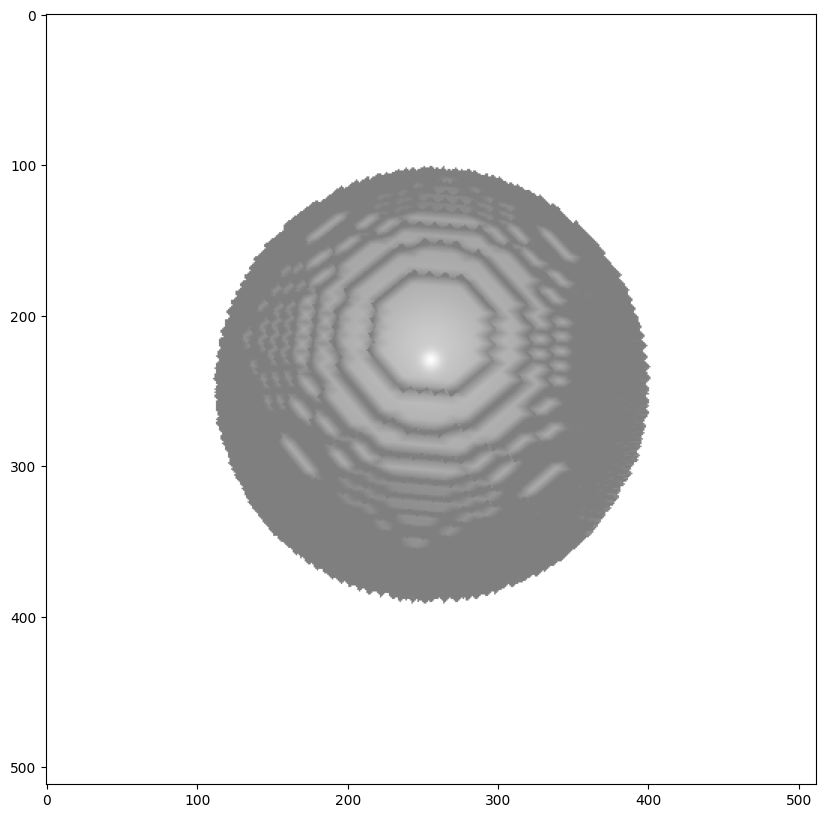

In [4]:
import torch
from pytorch3d.ops import cubify, taubin_smoothing
from pytorch3d.io import IO ,load_objs_as_meshes
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform,
    RasterizationSettings, BlendParams,
    MeshRenderer, MeshRasterizer, HardPhongShader,
    Textures
)
x_axis = [-1, 1]
y_axis = [-1, 1]
z_axis = [-1, 1]
depth = 64
height = 64
width = 64

#volume = torch.zeros([depth, height, width])
# some examples of surfaces defined implicitly
#sphere = lambda x: x[0]**2 + x[1]**2 + x[2]**2 - 0.8**2  #distances to the sphere surface
#torus = lambda x: (0.6 - torch.sqrt(x[0]**2 + x[1]**2))**2 + x[2]**2 - 0.3**2

#function = sphere
mesh1=torch.zeros([depth,height,width])
base1=torch.linspace(0,depth-1,depth)/(depth/2)-1
mesh1[:,:,:]+=pow(base1.unsqueeze(0).unsqueeze(0),2)
mesh1[:,:,:]+=pow(base1.unsqueeze(1).unsqueeze(0),2)
mesh1[:,:,:]+=pow(base1.unsqueeze(1).unsqueeze(2),2)
mesh1[:,:,:]-=0.64
mesh2=torch.zeros([depth,height,width])
mesh2[mesh1<=0]=1.0
mesh2[mesh1>0]=0.0

cubified = cubify(mesh2.unsqueeze(0), 0.7)
IO().save_mesh(cubified, "cubified_mesh.obj")

R, T = look_at_view_transform(2.7, 100, 50)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1, # sets the value of K
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardPhongShader(device=device, cameras=cameras)
)
mesh_batch3=load_objs_as_meshes(["./cubified_mesh.obj"]).to(device)
new_tex=torch.ones_like(mesh_batch3.verts_padded())
textures=Textures(verts_rgb=new_tex)
mesh_batch3.textures=textures
images = renderer(mesh_batch3, cameras=cameras)
plot_side_by_side(images)


Challenge B : *4* (must run after section 3 is run)


/usr/local/lib/python3.10/dist-packages/pytorch3d/ops/laplacian_matrices.py:177: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  L = torch.sparse.FloatTensor(e01, w01, (V, V))


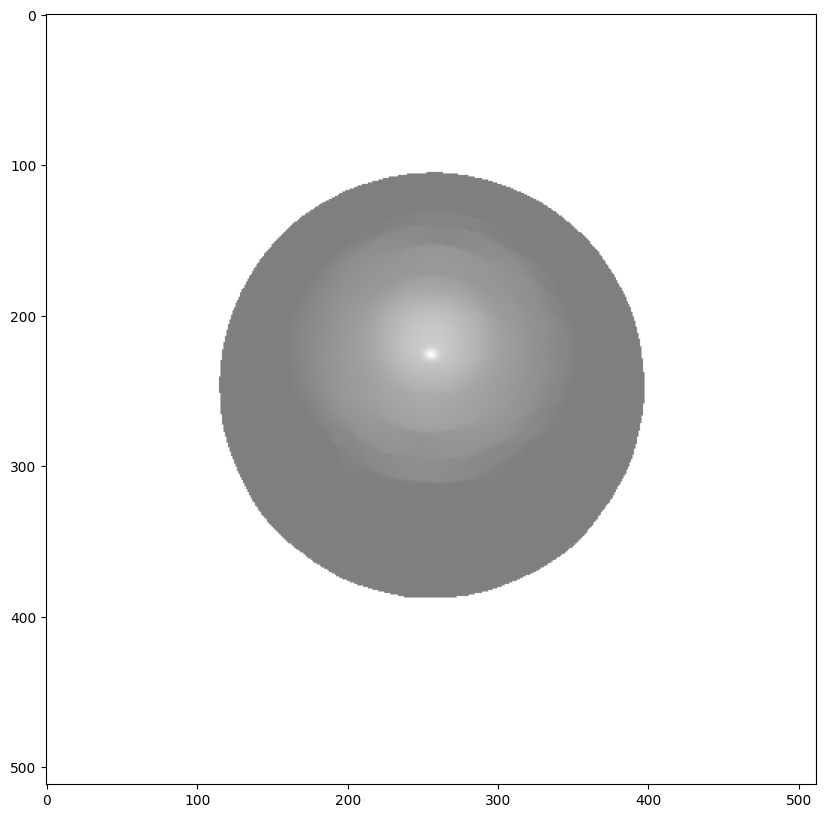

In [5]:
rounded=taubin_smoothing(cubified,num_iter=100)
IO().save_mesh(rounded, "rounded_mesh.obj")
R, T = look_at_view_transform(2.7, 100, 50)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
mesh_batch3=load_objs_as_meshes(["./rounded_mesh.obj"]).to(device)
new_tex=torch.ones_like(mesh_batch3.verts_padded())
textures=Textures(verts_rgb=new_tex)
mesh_batch3.textures=textures
images = renderer(mesh_batch3, cameras=cameras)
plot_side_by_side(images)

Challenge B : 5

Step1:train

Step2:eval

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

class occupancy(nn.Module):
  def __init__(self):
    super(occupancy, self).__init__()
    self.conv1=nn.Linear(3,128)
    self.conv2=nn.Linear(128,1)
    self.ReLU=nn.ReLU()
    self.Sigmoid=nn.Sigmoid()

  def forward(self,y):
    x=self.conv1(y)
    x=self.ReLU(x)
    x=self.conv2(x)
    x=self.Sigmoid(x)
    return x

def spheredatagenerator(batchsize=1024,radius=0.8):
  batch=torch.rand(batchsize,3)*2-1
  label=torch.zeros(batchsize,1)
  label[:,0] = ((batch[:,0]**2 + batch[:,1]**2 + batch[:,2]**2)<=radius**2).float()
  return batch.to(device),label.to(device)

network = occupancy().to(device)
optimizer = optim.Adam(network.parameters(), lr=0.01)
network.train()
l2loss=nn.MSELoss()
for i in range(1000):
  optimizer.zero_grad()
  src, label=spheredatagenerator()
  out=network(src)
  batch_loss=l2loss(out,label)
  batch_loss.backward()
  optimizer.step()
  if i%100==0:
    print(batch_loss)


torch.save(network.state_dict(),"./weights")



tensor(0.2376, grad_fn=<MseLossBackward0>)
tensor(0.0346, grad_fn=<MseLossBackward0>)
tensor(0.0220, grad_fn=<MseLossBackward0>)
tensor(0.0166, grad_fn=<MseLossBackward0>)
tensor(0.0153, grad_fn=<MseLossBackward0>)
tensor(0.0098, grad_fn=<MseLossBackward0>)
tensor(0.0112, grad_fn=<MseLossBackward0>)
tensor(0.0097, grad_fn=<MseLossBackward0>)
tensor(0.0094, grad_fn=<MseLossBackward0>)
tensor(0.0072, grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


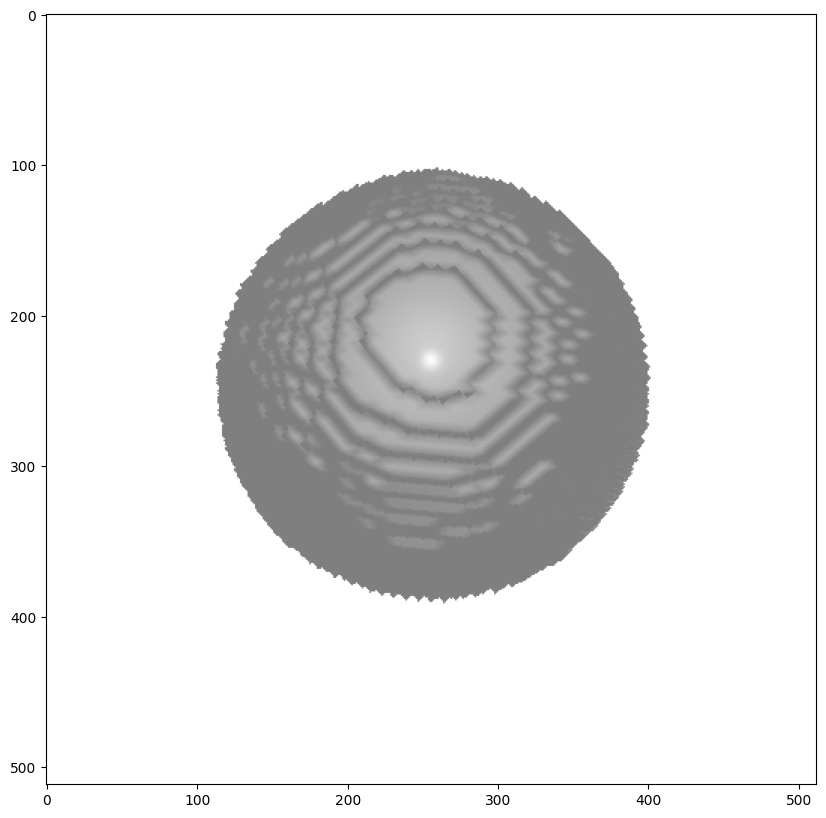

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch3d.ops import cubify, taubin_smoothing
from pytorch3d.io import IO
x_axis = [-1, 1]
y_axis = [-1, 1]
z_axis = [-1, 1]
depth = 64
height = 64
width = 64
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

class occupancy(nn.Module):
  def __init__(self):
    super(occupancy, self).__init__()
    self.conv1=nn.Linear(3,128)
    self.conv2=nn.Linear(128,1)
    self.ReLU=nn.ReLU()
    self.Sigmoid=nn.Sigmoid()

  def forward(self,y):
    x=self.conv1(y)
    x=self.ReLU(x)
    x=self.conv2(x)
    x=self.Sigmoid(x)
    return x

network=occupancy()
network.load_state_dict(torch.load("./weights"))
network.eval()

mesh1=torch.zeros([depth,height,width])
with torch.no_grad():
  for d in range(depth):
    for h in range(height):
      for w in range(width):
        x = (d - depth/2) / (depth/2)
        y = (h - height/2) / (height/2)
        z = (w - width/2) / (width/2)
        point = torch.tensor([x, y, z])
        if network(point) >=0.5:
         mesh1[d, h, w] = 1.0
cubified = cubify(mesh1.unsqueeze(0), 0.7)
IO().save_mesh(cubified, "predicted_mesh.obj")

R, T = look_at_view_transform(2.7, 100, 50)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
mesh_batch3=load_objs_as_meshes(["./predicted_mesh.obj"]).to(device)
new_tex=torch.ones_like(mesh_batch3.verts_padded())
textures=Textures(verts_rgb=new_tex)
mesh_batch3.textures=textures
images = renderer(mesh_batch3, cameras=cameras)
plot_side_by_side(images)